In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Joachim DAVID, December 2018
# Ghent University
# Zwijnaarde Industriepark 15
# 9000 Gent
# Joachim.David@UGent.be
#############################

# REFERENCES:
# http://reliawiki.org/index.php/The_Exponential_Distribution
# http://reliawiki.org/index.php/The_Weibull_Distribution
# @book{verma2010reliability,
#   title={Reliability and safety engineering},
#   author={Verma, Ajit Kumar and Ajit, Srividya and Karanki, Durga Rao},
#   volume={43},
#   chapter={2}
#   year={2010},
#   publisher={Springer}
# }
# @book{ebeling2004introduction,
#   title={An introduction to reliability and maintainability engineering},
#   author={Ebeling, C.E.},
#   isbn={9780070421387},
#   series={Electrical engineering series},
#   url={https://books.google.be/books?id=iFumyeVLIEAC},
#   year={2004},
#   publisher={McGraw-Hill}
# }

import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
pd.set_option('display.max_columns', None)
from visualize_lib import plot_gantt, show_energy_plot
from datetime import datetime, timedelta

#%cd D:\users\jdavid\Programming\GitHub\SchedulingSimulator\ELITEPython\Deliverable\original_data

#print(sys.path[0])
#import matplotlib
#matplotlib.matplotlib_fname()

filepath = 'original_data'
choices = {'prod': ('productionfile.csv', 'prod_speed.csv', 'productionfile_outputfile.xml', 'PastaType'),
           'pack': ('packagingfile_old.csv', 'pack_speed.csv', 'packagingfile_old_outputfile.xml', 'BigPack-simple')}
file_used, file_speed, file_info, choice = choices['prod']

round_to = 600 # seconds
break_pauses = 7200 # seconds # breaks will be split in these periods
turn_off_if = 3600 # seconds # the machine can be turned off if time if larger than this!!!! 
# turn_off_if has to be smaller than break_pauses in order for this program to run well
assert (turn_off_if < break_pauses)

In [3]:
from shutil import copyfile
copyfile(os.path.join(filepath, file_info), os.path.join(filepath, 'failureinfofile.xml'))

'original_data\\failureinfofile.xml'

In [4]:
filename = os.path.join(filepath, file_used)
df = pd.read_csv(filename, parse_dates=['StartDateUTC', 'EndDateUTC'])
df = df.sort_values('StartDateUTC')
all_reasons = list(df.ReasonId.unique())
all_reasons.sort()
print(all_reasons)

[0, 1, 2, 3, 5, 7, 8, 9, 10, 11]


In [5]:
# VARIABLES
# cutoff_perc = 100
# dtcutoff_perc = 100
reasons_relative = [1, 2, 3, 5, 7, 8]
reasons_absolute = [9, 10, 11]
reasons_break = []
reasons_not_considered = [0]
considered_reasons = reasons_relative + reasons_absolute + reasons_break
# group = True
# choice='PastaType'

# PLOT_RANGE:
plotrange = datetime(2016, 11, 3, 6, 0), datetime(2016, 12, 3, 0, 0)

assert (set(considered_reasons + reasons_not_considered) == set(all_reasons))

In [25]:
def add_column_type(df, from_col='ArticleName', choice='BigPack'):
    choices = ['BigPack', 'Marque', 'PastaType', 'BigPack-simple']
    newname = choice

    if newname == choices[0]:
        stringlist = [' 8', ' 10', ' 12', ' 16', ' 18' ,' 20']
    elif newname == choices[1]:
        stringlist = ['DLL 365', 'VALUE', 'AMBRA', 'EVERYDAY', 'WINNY', 'CARREFOUR', 'ALDI', 'ECO+', 'TOSCA', 'CASA ITALIANA',
                     'EUROSHOPPER', 'AH', 'PASTA MARE', 'OKE', 'TOP BUDGET', 'FIORINI', 'BIO VILLAGE', 'MONOPP', 'RINATURA',
                     'JUMBO', 'BONI', 'CASINO', 'TURINI']
    elif newname == choices[2]:
        stringlist = [['MACARONI', 'MAC.'], 'FUSILLI', ['SPIRELLI', 'SPIRAL', 'TORSADES'], ['HORENTJE', 'HELICES'], 
                      ['VERMICELLI', 'VERMICELL'], ['NOODLES', 'NOUILLES'], 'TORTI',
                     ['PENNE', 'PIPE'], ['ELLEBOOGJES', 'COQUILLETTE', 'COQ.'], 'ZITTI', 'MIE', 'NONE']
    elif newname == choices[3]:
        stringlist = [ ['SMALL', ' 8', ' 10', ' 12'], ['LARGE', ' 16', ' 18', ' 20']]
    else:
        raise NameError("The choice '{}' is not defined".format(newname))
    
    # Generate a new column with categories in the dataframe
    bp = np.full(df.shape[0], 'Other')
    name = df[from_col]
    for s in stringlist:
        if type(s) == list:
            new_s = ('|'.join(s))
            bp = np.where(name.str.contains(new_s), s[0], bp)
        else:
            if newname == 'BigPack':
                bp = np.where(name.str.contains(s), s + 'X', bp)
            else:
                bp = np.where(name.str.contains(s), s, bp)
    df[newname] = bp
    return df
df = add_column_type(df, choice=choice)

## Merge per production

### Merge per production, Absolute reasons

In [26]:
from probplot import merge_per_production
df_agg = merge_per_production(df, [choice, 'ProductionRequestId', 'Type', 'ReasonId'], considered_reasons)

In [27]:
print(df_agg.index.get_level_values(0).unique())
df_agg.tail()

Index(['ELLEBOOGJES', 'HORENTJE', 'MACARONI', 'MIE', 'Other', 'PENNE',
       'SPIRELLI', 'VERMICELLI', 'ZITTI'],
      dtype='object', name='PastaType')


DownTime1  DownTime2  DownTime3  DownTime5  \
PastaType ProductionRequestId                                               
ZITTI     75560.0                    0.0        0.0        0.0        0.0   
          75800.0                    0.0        0.0        0.0    18216.0   
          76046.0                    0.0        0.0        0.0     8123.0   
          76168.0                    0.0        0.0        0.0     1032.0   
          77204.0                    0.0        0.0        0.0    39637.0   

                               DownTime7  DownTime8  DownTime9  DownTime10  \
PastaType ProductionRequestId                                                
ZITTI     75560.0                    0.0        0.0        0.0      1794.0   
          75800.0                    0.0     1734.0        0.0      1096.0   
          76046.0                    0.0        0.0        0.0       700.0   
          76168.0                    0.0      338.0        0.0      1627.0   
          77204.0                    0.0        0.0        0.0      1675.0   

                               DownTime11  DownTime   RunTime  TotalDuration  \
PastaType ProductionRequestId                                                  
ZITTI     75560.0                 30533.0   32327.0   52313.0        84640.0   
          75800.0                 60444.0   81490.0  121826.0       203316.0   
          76046.0                321638.0  330461.0  209039.0       539500.0   
          76168.0                     0.0    2997.0   67397.0        70394.0   
          77204.0                     0.0   41312.0   76795.0       118107.0   

                               DownTimeRate  RunTimeRate  
PastaType ProductionRequestId                             
ZITTI     75560.0                  0.381935     0.618065  
          75800.0                  0.400805     0.599195  
          76046.0                  0.612532     0.387468  
          76168.0                  0.042575     0.957425  
          77204.0                  0.349785     0.650215

In [28]:
# def get_downtimes_absolute(df_agg, column):    
#     downtimes = []
#     lab = df_agg.index.get_level_values(0).unique()
#     for pastatype in lab:
#         temp_df = df_agg.loc[pastatype]
#         downtime9and10 = (temp_df[column])/3600
#         downtimes.append(downtime9and10)
#     return lab, downtimes
# cat, downtimes = get_downtimes_absolute(df_agg, 'Preparations')
# downtimes_dict = dict(zip(cat, downtimes))
# plt.boxplot(downtimes, vert=False, labels=cat)
# plt.show()

In [29]:
# from scipy.stats.mstats import f_oneway
# d_list = []
# for downt in downtimes:
#     d_list.append(np.array(downt))
# f = f_oneway(*d_list)
# print(f)
# if f.pvalue >= 0.05:
#     print('No statistical evidence of different distributions')
#     stat=False
# else:
#     print('Statistical evidence of different distributions')
#     stat=True

In [30]:
# from scipy.stats import ttest_ind
# from itertools import combinations, permutations
# import seaborn as sns; sns.set()
# row = list(df_agg.index.get_level_values(0).unique())
# pvalues_df = pd.DataFrame(1, row, row)
# for i, j in permutations(row, 2):
#     tt = ttest_ind(downtimes_dict[i], downtimes_dict[j])
#     pvalues_df.loc[i, j] = tt.pvalue
# plt.figure(figsize=(len(row), len(row)))
# sns.heatmap(pvalues_df, annot=True)
# plt.title('t-test probability of null hypothesis, Reasons: {}'.format(reasons_absolute))
# plt.yticks(rotation=0)
# #plt.savefig('D:/temp/ttest.png', dpi=300, layout='tight')
# plt.show()

In [31]:
row = list(df_agg.index.get_level_values(0).unique())
from scipy.stats.mstats import f_oneway
anova_list = []
for r in row:
    temp = df_agg.loc[r, 'RunTimeRate']
    anova_list.append(np.array(temp))
    #print(anova_list)
f = f_oneway(*anova_list)
print(f)
if f.pvalue >= 0.05:
    print('No statistical evidence of different distributions')
else:
    print('Statistical evidence of different distributions')

F_onewayResult(statistic=0.5969405128888211, pvalue=0.7810194146730409)
No statistical evidence of different distributions


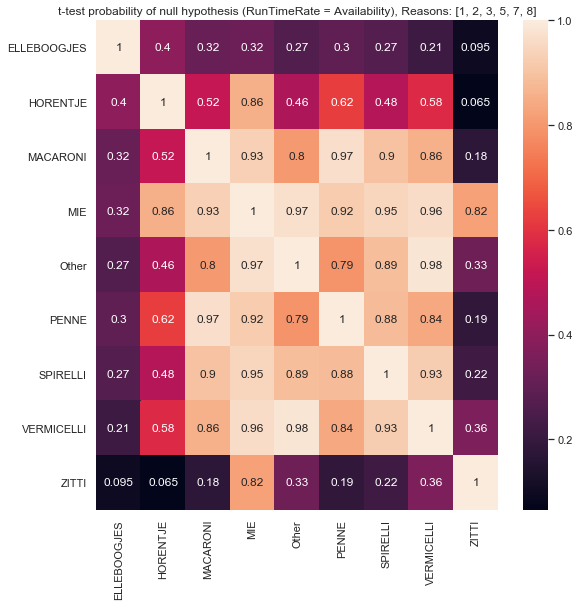

In [32]:
row = list(df_agg.index.get_level_values(0).unique())
from scipy.stats import ttest_ind
from itertools import combinations, permutations
import seaborn as sns; sns.set()
row = list(df_agg.index.get_level_values(0).unique())
pvalues_df = pd.DataFrame(1, row, row)
for i, j in permutations(row, 2):
    tt = ttest_ind(df_agg.loc[i, 'RunTimeRate'], df_agg.loc[j, 'RunTimeRate'])
    pvalues_df.loc[i, j] = tt.pvalue
plt.figure(figsize=(len(row), len(row)))
sns.heatmap(pvalues_df, annot=True)
plt.title('t-test probability of null hypothesis (RunTimeRate = Availability), Reasons: {}'.format(reasons_relative))
plt.yticks(rotation=0)
plt.savefig('D:/temp/ttest.png', dpi=300, bbox_inches ='tight')

In [33]:
all_reasons

[0, 1, 2, 3, 5, 7, 8, 9, 10, 11]

In [34]:
df_agg.columns

Index(['DownTime1', 'DownTime2', 'DownTime3', 'DownTime5', 'DownTime7',
       'DownTime8', 'DownTime9', 'DownTime10', 'DownTime11', 'DownTime',
       'RunTime', 'TotalDuration', 'DownTimeRate', 'RunTimeRate'],
      dtype='object')

In [35]:
from probplot import merge_per_article
df_merged = merge_per_article(df_agg, choice, all_reasons)

In [36]:
df_merged

,DownTime1,DownTime2,DownTime3,DownTime5,DownTime7,DownTime8,DownTime9,DownTime10,DownTime11,DownTime,RunTime,TotalDuration,DownTimeRate,DownTimeStd,Availability,DownTimeRate1,DownTimeRate2,DownTimeRate3,DownTimeRate5,DownTimeRate7,DownTimeRate8,DownTimeRate9
PastaType,,,,,,,,,,,,,,,,,,,,,,
ELLEBOOGJES,1766,0,344,13966,812,2388,746,17346,2749,40117,379762,419879,0.095544,0.106755,0.904456,0.006547,0.000000,0.000819,0.033262,0.001934,0.005687,0.001777
HORENTJE,38704,0,121518,658241,304540,67161,83766,278593,150053,1702576,8359704,10062280,0.169204,0.241432,0.830796,0.014912,0.000000,0.012077,0.065417,0.030266,0.006675,0.008325
MACARONI,158433,0,38397,499874,527815,59040,116751,259457,439684,2099451,7197294,9296745,0.225826,0.271584,0.774174,0.047294,0.000000,0.004130,0.053769,0.056774,0.006351,0.012558
MIE,149,0,0,4042,0,0,2413,7012,0,13616,69136,82752,0.164540,0.153695,0.835460,0.000000,0.000000,0.000000,0.048845,0.000000,0.000000,0.029159
Other,35038,2658,10916,300112,104742,50126,111324,198432,915350,1728698,4109034,5837732,0.296125,0.353534,0.703875,0.156799,0.000455,0.001870,0.051409,0.017942,0.008587,0.019070
PENNE,57514,0,80746,202972,182781,54929,22876,137853,23851,763522,3380888,4144410,0.184229,0.228351,0.815771,0.005755,0.000000,0.019483,0.048975,0.044103,0.013254,0.005520
SPIRELLI,23634,0,16066,409614,323415,44811,139908,146880,166044,1270372,4666029,5936401,0.213997,0.257722,0.786003,0.027970,0.000000,0.002706,0.069000,0.054480,0.007549,0.023568
VERMICELLI,24978,0,486,136727,96898,44794,15995,117702,399252,836832,2886744,3723576,0.224739,0.253853,0.775261,0.107223,0.000000,0.000131,0.036719,0.026023,0.012030,0.004296
ZITTI,96376,0,2752,183637,57531,49389,11301,71942,1543581,2016509,6066185,8082694,0.249485,0.227952,0.750515,0.190974,0.000000,0.000340,0.022720,0.007118,0.006110,0.001398


In [37]:
df_merged[['Availability', 'DownTimeStd']]

,Availability,DownTimeStd
PastaType,,
ELLEBOOGJES,0.904456,0.106755
HORENTJE,0.830796,0.241432
MACARONI,0.774174,0.271584
MIE,0.835460,0.153695
Other,0.703875,0.353534
PENNE,0.815771,0.228351
SPIRELLI,0.786003,0.257722
VERMICELLI,0.775261,0.253853
ZITTI,0.750515,0.227952


### Export for simulator file and visualise

In [38]:
def add_breaks(production, maxtime=7200):
    add_df = pd.DataFrame([], columns = production.columns)
    prid = -1
    for firstnumber, secondnumber in zip(production[:-1].T, production[1:].T):
        oldenddate = production.loc[firstnumber, 'EndDateUTC']
        newstartdate = production.loc[secondnumber, 'StartDateUTC']
        diff = (newstartdate - oldenddate).total_seconds()
        oldprid = production.loc[firstnumber, 'ProductionRequestId']
        newprid = production.loc[secondnumber, 'ProductionRequestId']
        # This loop counts out the breaks and splits it in periods of maxtime and one period of maxtime + diff
        while diff > 0:
            #print(diff)
            if diff > maxtime:
                new_row = pd.Series({'ProductionRequestId': int(prid),
                                     'StartDateUTC': oldenddate,
                                     'EndDateUTC': oldenddate + pd.Timedelta(maxtime, 's'),
                                     'Duration': maxtime,
                                     'ReasonId': 0,
                                     'ArticleName': 'NONE',
                                     'Quantity': int(maxtime/3600)})
                #print(maxtime)
                #print(maxtime/3600)
                diff -= maxtime
                oldenddate = oldenddate + pd.Timedelta(maxtime, 's')
            else: # diff <= maxtime
                # overwrite the break time
                new_row = pd.Series({'ProductionRequestId': int(prid),
                     'StartDateUTC': oldenddate,
                     'EndDateUTC': newstartdate,
                     'Duration': diff,
                     'ReasonId': 0,
                     'ArticleName': 'NONE',
                     'Quantity': int(diff/3600)})
                diff -= diff
            #oldprid = production.loc[firstnumber, 'ProductionRequestId']
            #newprid = production.loc[secondnumber, 'ProductionRequestId']
            #if oldprid != newprid:
            #    print('Not the same!')
            #    #print(firstnumber, diff, newstartdate)
            prid -= 1
#             else:
#                 new_row = pd.Series({'ProductionRequestId': oldprid,
#                                      'StartDateUTC': oldenddate,
#                                      'EndDateUTC': newstartdate,
#                                      'Duration': diff,
#                                      'ReasonId': 0,
#                                      'ArticleName': production.loc[firstnumber, 'ArticleName']})
            
            add_df = add_df.append(new_row, ignore_index=True)
        else:
            pass
    production = production.append(add_df, ignore_index=True)
    production = production.sort_values('StartDateUTC').reset_index(drop=True)
    return production

In [39]:
break_pauses

7200

In [40]:
df

,EquipmentId,ProductionRequestId,SegmentResponseId,StartDateUTC,EndDateUTC,Duration,ReasonId,IgnoreType,ArticleCode,ArticleName,Type,Quantity,PastaType
0,50,50675.0,74525.0,2016-01-19 14:21:47.980,2016-01-19 14:22:51.830,64.000,10,0,FF029001,MACARONI KORT PLATTE ZAK,DownTime,30000,MACARONI
1,50,50675.0,74525.0,2016-01-19 14:22:51.830,2016-01-19 17:23:51.660,10860.000,1,0,FF029001,MACARONI KORT PLATTE ZAK,RunTime,30000,MACARONI
2,50,50675.0,74525.0,2016-01-19 17:23:51.660,2016-01-19 17:30:45.690,414.000,8,0,FF029001,MACARONI KORT PLATTE ZAK,DownTime,30000,MACARONI
3,50,50675.0,74525.0,2016-01-19 17:30:45.690,2016-01-19 19:41:56.830,7871.000,1,0,FF029001,MACARONI KORT PLATTE ZAK,RunTime,30000,MACARONI
4,50,50675.0,74525.0,2016-01-19 19:41:56.830,2016-01-19 19:44:53.073,177.000,10,0,FF029001,MACARONI KORT PLATTE ZAK,DownTime,30000,MACARONI
5,50,50675.0,74525.0,2016-01-19 19:44:53.073,2016-01-19 19:49:18.047,265.000,1,0,FF029001,MACARONI KORT PLATTE ZAK,RunTime,30000,MACARONI
6,0,0.0,0.0,2016-01-19 19:49:18.047,2016-01-21 09:56:44.780,137246.733,0,0,000000EU,NONE,Break,0,NONE
7,50,50724.0,74711.0,2016-01-21 09:56:44.780,2016-01-21 09:58:50.930,126.000,9,0,FF011501,"GESNEDEN MACARONI AS 0,9%",DownTime,30000,MACARONI
8,50,50724.0,74711.0,2016-01-21 09:58:50.930,2016-01-21 10:51:08.090,3138.000,1,0,FF011501,"GESNEDEN MACARONI AS 0,9%",RunTime,30000,MACARONI
9,50,50724.0,74711.0,2016-01-21 10:51:08.090,2016-01-21 10:56:02.120,294.000,8,0,FF011501,"GESNEDEN MACARONI AS 0,9%",DownTime,30000,MACARONI


In [41]:
df_task = df.copy()
df_task['ReasonId'] = np.where(df_task.Type == 'RunTime', 100, df_task.ReasonId)
df_task = df_task[['ProductionRequestId', 'StartDateUTC' , 'EndDateUTC', 'Duration', 'ReasonId', 'ArticleName', 'Quantity']]
#df_task = df_task[df_task['StartDateUTC'] < df_task['StartDateUTC'][0] + pd.to_timedelta('14days')]
df_task = df_task[df_task.ArticleName != 'NONE']
#df_task = df_task[df_task.ProductionRequestId.isin(df.ProductionRequestId.unique()[10:40])]
df_task = add_breaks(df_task, maxtime=break_pauses)
df_task.head()

,ProductionRequestId,StartDateUTC,EndDateUTC,Duration,ReasonId,ArticleName,Quantity
0,50675,2016-01-19 14:21:47.980,2016-01-19 14:22:51.830,64,10,MACARONI KORT PLATTE ZAK,30000
1,50675,2016-01-19 14:22:51.830,2016-01-19 17:23:51.660,10860,100,MACARONI KORT PLATTE ZAK,30000
2,50675,2016-01-19 17:23:51.660,2016-01-19 17:30:45.690,414,8,MACARONI KORT PLATTE ZAK,30000
3,50675,2016-01-19 17:30:45.690,2016-01-19 19:41:56.830,7871,100,MACARONI KORT PLATTE ZAK,30000
4,50675,2016-01-19 19:41:56.830,2016-01-19 19:44:53.073,177,10,MACARONI KORT PLATTE ZAK,30000


In [38]:
df_prod  = df_task[df_task.ArticleName != 'NONE']
prodtime = df_prod.Duration.sum() / 3600
uptime = df_prod.Duration[df_prod.ReasonId.isin([100])].sum() / 3600
downtime = df_prod.Duration[df_prod.ReasonId.isin(all_reasons)].sum() / 3600

reltime = df_prod.Duration[df_prod.ReasonId.isin(reasons_relative)].sum() / 3600
abstime = df_prod.Duration[df_prod.ReasonId.isin(reasons_absolute)].sum() / 3600
breaktime = df_prod.Duration[df_prod.ReasonId.isin(reasons_break)].sum() / 3600

idletime = df_task.Duration[df_task.ArticleName == 'NONE'].sum() / 3600

print('Production time {:.3f} h'.format(prodtime))
print('> Runtime {:.3f} h'.format(uptime))
print('> Downtime {:.3f} h'.format(downtime))

print('>> Unexpected breakdowns {:.3f} h'.format(reltime))
print('>> Expected breaks {:.3f} h'.format(abstime))
print('>> Pause {:.3f} h'.format(breaktime))

print('Idle time {:.3f} h'.format(idletime))
print('Total time {:.3f} h'.format(prodtime + idletime))

av = uptime/prodtime
print('Availability production time:', av)

Production time 13218.464 h
> Runtime 10309.660 h
> Downtime 2908.804 h
>> Unexpected breakdowns 1414.120 h
>> Expected breaks 1494.684 h
>> Pause 0.000 h
Idle time 3121.736 h
Total time 16340.199 h
Availability production time: 0.7799438953959791


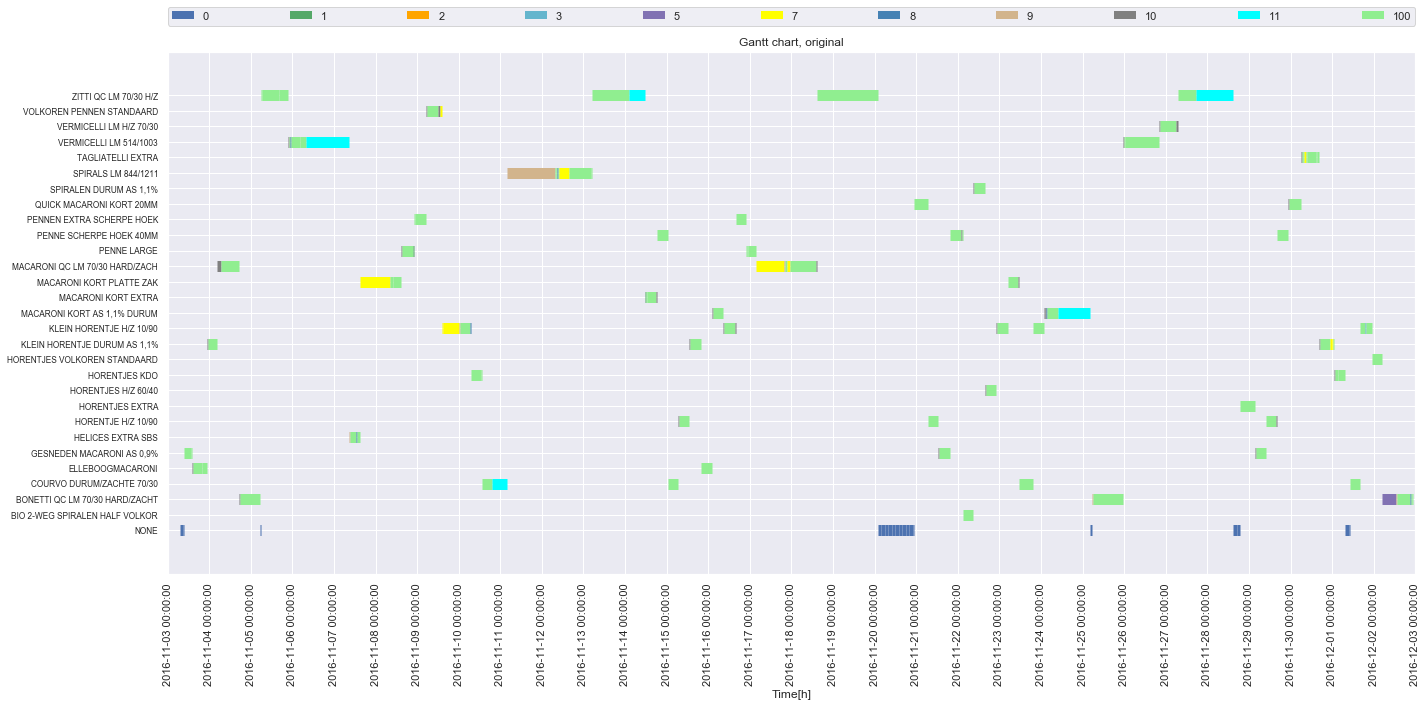

In [39]:
def show_gantt(df_task, start, end):
    plt.figure(figsize=(20, 10))
    # df_task['Start'] = (df_task.StartDateUTC - df_task.StartDateUTC[0].floor('D')).dt.total_seconds()/3600
    # df_task['End'] = (df_task.EndDateUTC - df_task.StartDateUTC[0].floor('D')).dt.total_seconds()/3600
    df_part = df_task[df_task.StartDateUTC.between(start, end) & df_task.EndDateUTC.between(start, end)]
    all_reasons = list(df_task.ReasonId.unique())
    all_reasons.sort()
    plot_gantt(df_part, 'ReasonId', 'ArticleName', order=all_reasons)
    # handles, labels = plt.gca().get_legend_handles_labels()
    # by_label = dict(zip(labels, handles))
    # key_list = sorted(by_label)
    # value_list = [by_label[key] for key in key_list]
    # plt.legend(value_list, key_list, loc='lower right')
    plt.title('Gantt chart, original')
    #try:
    #    plt.savefig('D:/temp/gantt.svg', dpi=1200, bbox_inches='tight')
    #except:
    #    pass
    plt.tight_layout()
    plt.show()
show_gantt(df_task, *plotrange)

In [40]:
def sliding_plot(start, ran):
    from datetime import datetime, timedelta

    plotrange = datetime(2016, 1, 19, 0, 0) + timedelta(start), datetime(2016, 1, 25, 0, 0) + timedelta(start+ran)

    show_gantt(df_task, *plotrange)

In [41]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

a = widgets.FloatText()
b = widgets.FloatSlider(min=0, max=100, step=1)
display(a)
c = widgets.FloatSlider(min=1, max=14, step=1)

mylink = widgets.jslink((a, 'value'), (b, 'value'))

interact(sliding_plot, start=b, ran=7)

FloatText(value=0.0)

interactive(children=(FloatSlider(value=0.0, description='start', step=1.0), IntSlider(value=7, description='r…

<function __main__.sliding_plot>

In [42]:
#import os
#os.chdir(r'D:\users\jdavid\Programming\GitHub\SchedulingSimulator\ELITEPython\Revised')

In [44]:
def group_productions(df_task):
    group = df_task.groupby('ProductionRequestId').agg({'Quantity':'first','StartDateUTC':'min', 'EndDateUTC':'max', 'ArticleName':'first'}).sort_values(by='StartDateUTC')
    #print(len(group))
    # all of the uptime is counted here
    group_uptime = df_task[df_task.ReasonId.isin([100])].groupby('ProductionRequestId').agg({'Duration':'sum'})
    group_uptime.columns = ['Uptime']
    group_alltime = df_task.groupby('ProductionRequestId').agg({'Duration':'sum'})
    group_alltime.columns = ['Totaltime']
    group_downtime = df_task[df_task.ReasonId.isin(considered_reasons)].groupby('ProductionRequestId').agg({'Duration':'sum'})
    group_downtime.columns = ['Downtime']
    group = pd.concat([group_uptime, group_downtime, group_alltime, group], axis=1)
    group.loc[group.ArticleName == 'NONE', 'Uptime'] = group.loc[group.ArticleName == 'NONE', 'Totaltime']
    group = group.sort_values(by='StartDateUTC')
    group.index = group.index.astype(int)
    group = group.fillna(0)
    return group

def simplify_productions(group, num_minutes):
    df = group.copy()
    #df['Duration'] = df['Duration'] * 60
    #df['Duration'] = df['Duration'].apply(np.round).astype(int)
    #df['Duration'] = round(df['Duration'] / num_minutes) * num_minutes # rounds down to the chosen numbers of seconds
    i = 0
#    for j, k in zip(df.iloc[:-1].T, df.iloc[1:].T):
#         if i == 0:
#             df.loc[j, 'StartDateUTC'] = df.loc[j, 'StartDateUTC'].round(str(num_minutes) + 's')
#             df.loc[j, 'EndDateUTC'] = df.loc[j, 'StartDateUTC'] + pd.Timedelta(seconds = df.loc[j, 'Duration'])
#             i += 1
#         df.loc[k, 'StartDateUTC'] = df.loc[j, 'EndDateUTC']
#         df.loc[k, 'EndDateUTC'] = df.loc[k, 'StartDateUTC'] + pd.Timedelta(seconds = df.loc[k, 'Duration'])
#        df.loc[j, ]

    df['StartDateUTC'] = df['StartDateUTC'].dt.round(str(num_minutes) + 's')
    df['EndDateUTC'] = df['EndDateUTC'].dt.round(str(num_minutes) + 's')
    df['Duration'] = (df['EndDateUTC'] - df['StartDateUTC']).dt.total_seconds()
    df = df[df['Duration'] > 0]
    #df['Duration'] = df['Duration']/60
    return df

def remove_breaks(group, min_length=3600):
    df = group.copy()
    j = 0
    while j < len(df):
        temp = df.iloc[j]
        if (temp['ArticleName'] == 'NONE') & (temp['Totaltime'] < min_length):
            # don't turn off the machine (no energy saving)
            curidx = temp.name
            previdx = df.iloc[j-1].name
            if (j > 0): #& (df.loc[previdx, 'ArticleName'] != 'NONE'):
                # extend the previous job
                df.loc[previdx, 'EndDateUTC'] = df.loc[curidx, 'EndDateUTC']
                df.loc[previdx, 'Totaltime'] += df.loc[curidx, 'Totaltime']
                df.loc[previdx, 'Uptime'] += df.loc[curidx, 'Uptime']
                df.loc[previdx, 'Downtime'] += df.loc[curidx, 'Downtime']
                df = df.drop(curidx)
                j -= 1
            else:
                pass
                #print('Something unexpected happened!')
                #print(curidx, df.loc[previdx, 'ArticleName'])
        j += 1
    return df
                    

def save_durations(group, output, beforedays=None, afterdays=None, randomfactor=None, ignore_break=True):
    out = group[['Uptime', 'Totaltime', 'Quantity', 'StartDateUTC', 'EndDateUTC', 'ArticleName']].copy()
    out.columns = ['Uptime', 'Totaltime', 'Quantity', 'Start', 'End', 'Product']
    out[['Uptime', 'Totaltime']] = out[['Uptime', 'Totaltime']] / 3600
    out = add_column_type(out , 'Product', 'PastaType')
    out.columns.values[-1] = 'Type'
    to_convert_dates = ['Start', 'End']
    
    # add due date before
    if afterdays:
        beforetime = np.full(np.array(out['End']).shape, afterdays)
        if randomfactor:
            beforetime += np.random.randint(randomfactor + 1, size=beforetime.shape)
        out['After'] = pd.to_datetime(out['End']) - pd.to_timedelta(beforetime, unit="D")
        if ignore_break:
            out.loc[out['Product'] == 'NONE', 'After'] = pd.Timestamp.min
        to_convert_dates.append('After')
    
    # add first possible production date
    if beforedays:
        addedtime = np.full(np.array(out['End']).shape, beforedays)
        if randomfactor:
            addedtime += np.random.randint(randomfactor + 1, size=addedtime.shape)
        out['Before'] = pd.to_datetime(out['End']) + pd.to_timedelta(addedtime, unit="D")
        if ignore_break:
            out.loc[out['Product'] == 'NONE', 'Before']= pd.Timestamp.max
        to_convert_dates.append('Before')

    for col in to_convert_dates:
        out[col] = out[col].dt.strftime("%Y-%m-%d %H:%M:%S.%f")
    out.index.name = 'ID'
    out.to_csv(output)
    
def construct_downtimes(group, reasons):
    dt = group.copy()
    dt = dt[dt['ReasonId'].isin(reasons)]
    return dt

def save_downtimes(dt, output):
    out = dt.copy()
    out = out[['StartDateUTC', 'EndDateUTC']]
    out = out.reset_index(drop=True)
    out.index.name = 'ID'
    out.to_csv(output)

#print(len(df_task))
group = group_productions(df_task)
#print(len(group))
print(group.columns)
group = remove_breaks(group, turn_off_if)
len(group)
#group = simplify_productions(group, 600)
#print(len(group))
downtime = construct_downtimes(df_task, considered_reasons)
save_downtimes(downtime, os.path.join(filepath, 'historicalDownPeriods.csv'))

Index(['Uptime', 'Downtime', 'Totaltime', 'Quantity', 'StartDateUTC',
       'EndDateUTC', 'ArticleName'],
      dtype='object')


In [45]:
group

,Uptime,Downtime,Totaltime,Quantity,StartDateUTC,EndDateUTC,ArticleName
ProductionRequestId,,,,,,,
50675,18996.000,655.0,19651.000,30000,2016-01-19 14:21:47.980,2016-01-19 19:49:18.047,MACARONI KORT PLATTE ZAK
-1,7200.000,0.0,7200.000,2,2016-01-19 19:49:18.047,2016-01-19 21:49:18.047,NONE
-2,7200.000,0.0,7200.000,2,2016-01-19 21:49:18.047,2016-01-19 23:49:18.047,NONE
-3,7200.000,0.0,7200.000,2,2016-01-19 23:49:18.047,2016-01-20 01:49:18.047,NONE
-4,7200.000,0.0,7200.000,2,2016-01-20 01:49:18.047,2016-01-20 03:49:18.047,NONE
-5,7200.000,0.0,7200.000,2,2016-01-20 03:49:18.047,2016-01-20 05:49:18.047,NONE
-6,7200.000,0.0,7200.000,2,2016-01-20 05:49:18.047,2016-01-20 07:49:18.047,NONE
-7,7200.000,0.0,7200.000,2,2016-01-20 07:49:18.047,2016-01-20 09:49:18.047,NONE
-8,7200.000,0.0,7200.000,2,2016-01-20 09:49:18.047,2016-01-20 11:49:18.047,NONE


In [44]:
def energy_per_production(group, file_speed, choice=None, df_merged=None):
    articlenum = len(group.ArticleName.unique())
    fs = pd.read_csv(file_speed, index_col=0)
    fs = fs[fs.ProductDescription.isin(list(group.ArticleName))].reset_index(drop=True)
    #print(fs.ProductDescription)
    rand1 = pd.Series(np.random.random_sample((len(fs),)) * 0.5 + 0.3)    # unit price
    rand2 = pd.Series(np.random.random_sample((len(fs),)) * 1 + 0.5)  # power
    energycons = pd.concat([pd.Series(fs.ProductDescription), 
                            rand1,
                            rand2, 
                            pd.Series(fs.TargetProductionRate)], axis=1)
    if choice:
        assert(df_merged is not None)
        energycons = add_column_type(energycons, from_col='ProductDescription', choice=choice)
        energycons = energycons.merge(df_merged[['Availability']], left_on=choice, right_index=True)
        energycons = energycons.drop(choice, axis=1)
        energycons.columns = ['Product', 'UnitPrice',  'Power', 'TargetProductionRate', 'Availability']
    else:
        energycons.columns = ['Product', 'UnitPrice',  'Power', 'TargetProductionRate']
    #energycons.insert(1, 'UnitPrice', 5)
    #energycons.insert(len(energycons.columns), 'TargetProductionRate', 3000)
    #energycons.loc[energycons.Product == 'NONE', 'Power'] = 0
    if choice:
        energycons = energycons.append({'Product': 'NONE', 'UnitPrice': 0, 'Power': 0, 'TargetProductionRate': 1,
                                       'Availability': 1}, ignore_index=True)
        energycons = energycons.append({'Product': 'MAINTENANCE', 'UnitPrice': 0, 'Power': 0, 'TargetProductionRate': 1,
                                       'Availability': 1}, ignore_index=True)
    else:
        energycons = energycons.append({'Product': 'NONE', 'UnitPrice': 0, 
                                        'Power': 0, 'TargetProductionRate': 1}, ignore_index=True)
        energycons = energycons.append({'Product': 'MAINTENANCE', 'UnitPrice': 0, 'Power': 0, 
                                        'TargetProductionRate': 1}, ignore_index=True)
    return energycons

energycons = energy_per_production(group, os.path.join(filepath, file_speed), choice=choice, df_merged=df_merged)
# energycons = add_column_type(energycons, 'Product', 'PastaType')
# energycons.columns.values[-1] = 'Type'
energycons.to_csv(os.path.join(filepath, 'generated_productRelatedCharacteristics.csv'), index=False)

In [45]:
group = add_column_type(group, choice=choice)

In [46]:
group.head()

,Uptime,Downtime,Totaltime,Quantity,StartDateUTC,EndDateUTC,ArticleName,PastaType
ProductionRequestId,,,,,,,,
50675,18996.0,655.0,19651.0,30000,2016-01-19 14:21:47.980,2016-01-19 19:49:18.047,MACARONI KORT PLATTE ZAK,MACARONI
-1,7200.0,0.0,7200.0,2,2016-01-19 19:49:18.047,2016-01-19 21:49:18.047,NONE,NONE
-2,7200.0,0.0,7200.0,2,2016-01-19 21:49:18.047,2016-01-19 23:49:18.047,NONE,NONE
-3,7200.0,0.0,7200.0,2,2016-01-19 23:49:18.047,2016-01-20 01:49:18.047,NONE,NONE
-4,7200.0,0.0,7200.0,2,2016-01-20 01:49:18.047,2016-01-20 03:49:18.047,NONE,NONE


In [47]:
prodtime = group.Totaltime[group.ArticleName != 'NONE'].sum() / 3600
print('Production time {:.3f} h'.format(prodtime))
idletime = group.Totaltime[group.ArticleName == 'NONE'].sum() / 3600
print('Idle time {:.3f} h'.format(idletime))
print('Total time {:.3f} h'.format(prodtime + idletime))

Production time 13299.259 h
Idle time 3040.940 h
Total time 16340.199 h


In [48]:
group

,Uptime,Downtime,Totaltime,Quantity,StartDateUTC,EndDateUTC,ArticleName,PastaType
ProductionRequestId,,,,,,,,
50675,18996.000,655.0,19651.000,30000,2016-01-19 14:21:47.980,2016-01-19 19:49:18.047,MACARONI KORT PLATTE ZAK,MACARONI
-1,7200.000,0.0,7200.000,2,2016-01-19 19:49:18.047,2016-01-19 21:49:18.047,NONE,NONE
-2,7200.000,0.0,7200.000,2,2016-01-19 21:49:18.047,2016-01-19 23:49:18.047,NONE,NONE
-3,7200.000,0.0,7200.000,2,2016-01-19 23:49:18.047,2016-01-20 01:49:18.047,NONE,NONE
-4,7200.000,0.0,7200.000,2,2016-01-20 01:49:18.047,2016-01-20 03:49:18.047,NONE,NONE
-5,7200.000,0.0,7200.000,2,2016-01-20 03:49:18.047,2016-01-20 05:49:18.047,NONE,NONE
-6,7200.000,0.0,7200.000,2,2016-01-20 05:49:18.047,2016-01-20 07:49:18.047,NONE,NONE
-7,7200.000,0.0,7200.000,2,2016-01-20 07:49:18.047,2016-01-20 09:49:18.047,NONE,NONE
-8,7200.000,0.0,7200.000,2,2016-01-20 09:49:18.047,2016-01-20 11:49:18.047,NONE,NONE


In [49]:
save_durations(group, os.path.join(filepath,'generated_jobInfoProd.csv'), beforedays=7, afterdays=7, randomfactor=3)
# reasonlist = np.where(np.array(group['ArticleName']) == 'NONE', 0, 100) 
# group['ReasonId'] = reasonlist

In [50]:
group.head(80)

,Uptime,Downtime,Totaltime,Quantity,StartDateUTC,EndDateUTC,ArticleName,PastaType
ProductionRequestId,,,,,,,,
50675,18996.000,655.0,19651.000,30000,2016-01-19 14:21:47.980,2016-01-19 19:49:18.047,MACARONI KORT PLATTE ZAK,MACARONI
-1,7200.000,0.0,7200.000,2,2016-01-19 19:49:18.047,2016-01-19 21:49:18.047,NONE,NONE
-2,7200.000,0.0,7200.000,2,2016-01-19 21:49:18.047,2016-01-19 23:49:18.047,NONE,NONE
-3,7200.000,0.0,7200.000,2,2016-01-19 23:49:18.047,2016-01-20 01:49:18.047,NONE,NONE
-4,7200.000,0.0,7200.000,2,2016-01-20 01:49:18.047,2016-01-20 03:49:18.047,NONE,NONE
-5,7200.000,0.0,7200.000,2,2016-01-20 03:49:18.047,2016-01-20 05:49:18.047,NONE,NONE
-6,7200.000,0.0,7200.000,2,2016-01-20 05:49:18.047,2016-01-20 07:49:18.047,NONE,NONE
-7,7200.000,0.0,7200.000,2,2016-01-20 07:49:18.047,2016-01-20 09:49:18.047,NONE,NONE
-8,7200.000,0.0,7200.000,2,2016-01-20 09:49:18.047,2016-01-20 11:49:18.047,NONE,NONE


In [51]:
energycons.tail(2)

,Product,UnitPrice,Power,TargetProductionRate,Availability
42,NONE,0.0,0.0,1,1.0
43,MAINTENANCE,0.0,0.0,1,1.0


In [52]:
startdate = group.StartDateUTC.min()
firstofmonth = (startdate - pd.offsets.MonthBegin(1)).floor('D')
enddate = group.StartDateUTC.max()
lastofmonth = (enddate + pd.offsets.MonthEnd(1)).ceil('D')
lastofmonth

def construct_energy_2tarifs(ran, daytarif, nighttarif, starttime, endtime):
    ind = pd.date_range(freq='H', start=ran[0], end=ran[1])
    prices = pd.DataFrame([daytarif] * len(ind), index=ind)
    night = (ind.weekday >= 5) | (ind.hour < endtime) | (ind.hour >= starttime) # saturday or sunday, after 21 and before 6
    prices[night] = nighttarif
    prices.columns = ['Euro']
    prices.index.name = 'Date'
    #prices = prices.loc[prices['Euro'].diff(1) != 0]
    return prices

prices = construct_energy_2tarifs((firstofmonth, lastofmonth), 12, 8, 21, 6)
prices.to_csv(os.path.join(filepath, 'generated_hourly_energy_price.csv'))
prices.head()

,Euro
Date,
2016-01-01 00:00:00,8
2016-01-01 01:00:00,8
2016-01-01 02:00:00,8
2016-01-01 03:00:00,8
2016-01-01 04:00:00,8


In [53]:
def calculate_energy_cost(df_tasks, df_cost, df_cons, return_table=False):
    lastenddate = df_tasks.iloc[-1]['EndDateUTC']
    new_row = pd.Series({'ProductionRequestId': -1000,
                     'StartDateUTC': lastenddate,
                     'EndDateUTC': lastenddate + pd.Timedelta(1, 's'),
                     'Duration': 1,
                     'ReasonId': 0,
                     'ArticleName': 'NONE'})
    df_tasks = df_tasks.append(new_row, ignore_index=True)
    #print(df_tasks)
    
    # Set timedateindex
    df_tasks = df_tasks.merge(df_cons, how='left', left_on='ArticleName', right_on='Product').set_index('StartDateUTC', drop=True)
    
    # Concatenate the list of tasks and the energy cost on axis 0
    out_table = pd.concat([df_tasks, df_cost]).sort_index()
    out_table = out_table[df_tasks.index[0]: df_tasks.index[-1]]
    
    
    # Determine the length of each time interval
    # Make a new index with all changes and their length in hours
    alldates = out_table.index
    times = -pd.Series(((alldates - pd.Timestamp("1970-01-01")) / pd.Timedelta('1s'))).diff(-1)
    out_table = out_table.reset_index(drop=True)
    out_table['Difftime'] = times
    out_table.index = alldates
    out_table = out_table.iloc[:-1]
    out_table = out_table[['Product', 'Difftime', 'Euro', 'Power']].ffill().bfill()

    out_table = out_table[out_table.Difftime > 0]
    
    out_table['Price'] = (out_table['Difftime'] * out_table['Euro'] * out_table['Power']) / 3600
    total_sum = out_table['Price'].sum()
    
    if return_table:
        return total_sum, out_table
    else:
        return total_sum

In [54]:
downtime.head(2)

,ProductionRequestId,StartDateUTC,EndDateUTC,Duration,ReasonId,ArticleName,Quantity
0,50675,2016-01-19 14:21:47.980,2016-01-19 14:22:51.830,64,10,MACARONI KORT PLATTE ZAK,30000
2,50675,2016-01-19 17:23:51.660,2016-01-19 17:30:45.690,414,8,MACARONI KORT PLATTE ZAK,30000


In [55]:
plotrange[0]

datetime.datetime(2016, 11, 3, 6, 0)

C:\Users\jdavid\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()
C:\Users\jdavid\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\jdavid\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

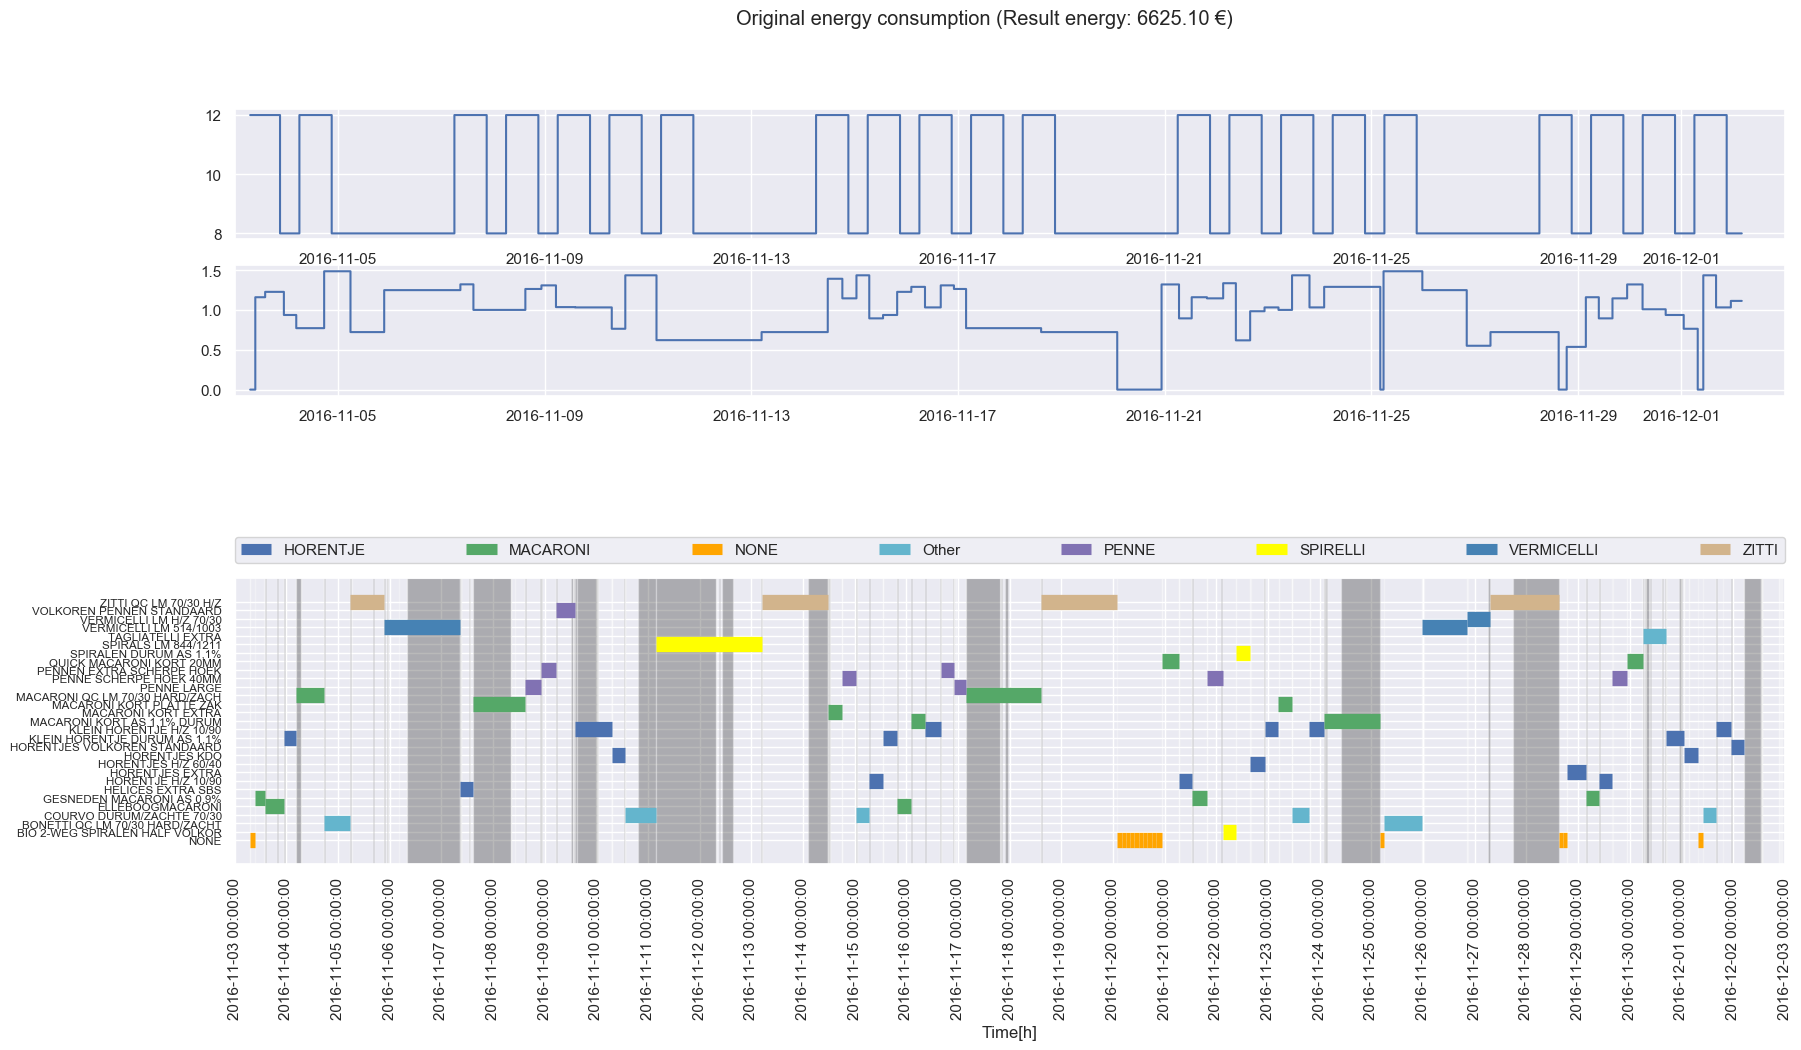

In [56]:
group_part = group[(group.StartDateUTC >= plotrange[0]) & (group.EndDateUTC <= plotrange[1])]
downtime_temp = downtime[downtime.StartDateUTC.between(*plotrange)]

plt.figure(figsize=(20, 10), dpi=100)
c, table = calculate_energy_cost(group_part, prices, energycons, True)

plt.subplot(5,1,(4,5))
timerange = plot_gantt(add_column_type(group_part, choice=choice), choice, 'ArticleName', downtimes=downtime_temp)
plt.subplot(5,1,1)
plt.suptitle('Original energy consumption (Result energy: {:.2f} €)'.format(c))
plt.xlim(timerange[0], timerange[-1])
plt.plot(table.Euro, drawstyle='steps-post')

plt.subplot(5,1,2)
plt.xlim(timerange[0], timerange[-1])
plt.plot(table.Power, drawstyle='steps-post')
try:
    plt.savefig('D:/temp/gantt_detailed.svg', dpi=1200, bbox_inches='tight')
except:
    print('No output made.')
    pass
plt.show()

In [57]:
group_part.head(5)

,Uptime,Downtime,Totaltime,Quantity,StartDateUTC,EndDateUTC,ArticleName,PastaType
ProductionRequestId,,,,,,,,
-1491,8562.240,0.0,8562.240,2,2016-11-03 07:08:12.890,2016-11-03 09:30:55.130,NONE,NONE
61962,15621.000,859.0,16480.000,40000,2016-11-03 09:30:55.130,2016-11-03 14:05:35.653,"GESNEDEN MACARONI AS 0,9%",MACARONI
62082,29329.990,1974.0,31303.990,45000,2016-11-03 14:05:35.653,2016-11-03 22:47:19.140,ELLEBOOGMACARONI,MACARONI
62179,19469.000,1236.0,20705.000,30000,2016-11-03 22:47:19.140,2016-11-04 04:32:24.930,"KLEIN HORENTJE DURUM AS 1,1%",HORENTJE
62022,38393.004,8257.0,46650.004,35000,2016-11-04 04:32:24.930,2016-11-04 17:29:54.697,MACARONI QC LM 70/30 HARD/ZACH,MACARONI


In [58]:
# start_time = pd.Timestamp(np.array(group.loc[:, ['StartDateUTC', 'EndDateUTC']]).min())
# end_time = pd.Timestamp(np.array(group.loc[:, ['StartDateUTC', 'EndDateUTC']]).max())
# start_time, end_time

In [59]:
break

SyntaxError: 'break' outside loop (<ipython-input-59-6aaf1f276005>, line 1)

In [ ]:
from SchedulerV000 import run_opt
files = [os.path.join(filepath, f) for f in ['historicalDownPeriods.csv',
                                             '',
                                             'generated_productRelatedCharacteristics.csv', 
                                             'generated_hourly_energy_price.csv', 
                                             'generated_jobInfoProd.csv']]
best_result, orig_result, best_sched, orig_sched, best_curve, mean_curve, worst_curve, gen = run_opt(*plotrange, 
        *files, 
        1, 10000, 0.4, 0.4, 12, num_mutations=1, adaptive=[],
        stop_condition='num_iterations', stop_value=1000, 
        weight_energy = 1, weight_failure=0, weight_conversion = 1, weight_constraint = 10000)

In [ ]:
best_sched = list(best_sched.keys())

In [ ]:
def reorder_schedule(id_list, schedule):
    df = schedule.loc[id_list]
    startdate = df['StartDateUTC'].min()
    #print(df)
    for row in df.T:
        df.loc[row, 'StartDateUTC'] = startdate
        enddate = startdate + pd.Timedelta(df.loc[row, 'Totaltime'], unit='s')
        df.loc[row, 'EndDateUTC'] = enddate
        startdate = enddate
    return df

In [ ]:
group_opt = reorder_schedule(best_sched, group)
reasonlist = np.where(np.array(group_opt['ArticleName']) == 'NONE', 0, 100) 
group_opt['ReasonId'] = reasonlist
group_opt.head()

In [ ]:
plt.plot(best_curve)
plt.plot(mean_curve)
plt.plot(worst_curve)

In [ ]:
group_opt.head(10)

In [ ]:
plt.figure(figsize=(20, 15))
show_energy_plot(add_column_type(group_opt, choice=choice), prices, energycons, 'Best schedule (GA)', choice, 
                 downtimes=downtime_temp)
plt.show()

In [ ]:
# group_part = group_opt[group_opt.StartDateUTC.between(*plotrange)]
# downtime_temp = downtime[downtime.StartDateUTC.between(*plotrange)]

# plt.figure(figsize=(20, 10))
# c, table = calculate_energy_cost(group_part, prices, energycons, True)

# plt.subplot(5,1,(4,5))
# timerange = plot_gantt(add_column_type(group_part, choice='PastaType'), 'PastaType', 'ArticleName', downtimes=downtime_temp)
# plt.subplot(5,1,1)
# plt.suptitle('Original energy consumption (Result energy: {:.2f} €)'.format(c))
# plt.xlim(timerange[0], timerange[-1])
# plt.plot(table.Euro, drawstyle='steps-post')

# plt.subplot(5,1,2)
# plt.xlim(timerange[0], timerange[-1])
# plt.plot(table.Power, drawstyle='steps-post')
# try:
#     plt.savefig('D:/temp/gantt_detailed.svg', dpi=1200, bbox_inches='tight')
# except:
#     print('No output made.')
#     pass
# plt.show()

In [ ]:
# df_task = df[['StartDateUTC', 'EndDateUTC', 'ArticleName', 'Type']]
# df_task.columns = ['Start', 'Finish', 'Task', 'Resource']
# df_task = df_task.iloc[1:2000]
# df_task = df_task.reset_index(drop=True)
# df_task.head()

In [ ]:
# df_task.Resource.unique()

In [ ]:
# import plotly.plotly as py
# import plotly.figure_factory as ff
# # colors = {'DownTime': 'rgb(220, 0, 0)',
# #           'RunTime': 'rgb(0, 255, 100)',
# #          'Break': 'rgb(255, 230, 25)'}
# fig = ff.create_gantt(df_task, group_tasks=True, show_colorbar=True)
# py.iplot(fig, world_readable=True)

In [ ]:
#     df_temp = df[]
#     from probdist import duration_between_downtime
#     bool_up = (df.Type == 'RunTime') # List of all RunTimes
#     bool_down = (df.Type == 'DownTime') & (df.ReasonId.isin(reasons_considered)) # List of all DownTimes in calculation
#     # Will ignore types of DownTimes not in the list
#     duration = duration_between_downtime(list(df.Duration), list(bool_up), list(bool_down)) / 3600 # hours